## Imports


In [2]:
!conda activate base
!pip install torch
!pip install torchvision


In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

## Hyper Parameters

In [22]:
batch_size = 16  # Smaller batch size
learning_rate = 0.001
num_epochs = 30
train_split = 0.8  # 80% for training, 20% for testing


## Data Augmentation

In [23]:
# load data and apply initial transform
dataset_path = 'Soil Data'
dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())

# data augmentation
augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
])
dataset.transform = augmentation

# split dataset
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model


In [24]:
# define CNN model
class SandNet(nn.Module):
    def __init__(self):
        super(SandNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 5) 

    def forward(self, x):
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv1(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv2(x)))
        x = nn.MaxPool2d(2)(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# init model and optimizer
model = SandNet()
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

## Train model


In [25]:

epoch_losses = []
epoch_accuracies = []

# train model
for epoch in range(num_epochs):
    running_loss = 0.0  
    correct, total = 0,0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # accumulate running loss
        running_loss += loss.item()
        
        # accumulate correct predictions for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # calculate and store average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")




Epoch 1 - Loss: 1.2502, Accuracy: 53.82%
Epoch 2 - Loss: 1.1035, Accuracy: 57.80%
Epoch 3 - Loss: 0.9474, Accuracy: 62.08%
Epoch 4 - Loss: 0.8827, Accuracy: 65.44%
Epoch 5 - Loss: 0.8119, Accuracy: 61.77%
Epoch 6 - Loss: 0.7238, Accuracy: 67.28%
Epoch 7 - Loss: 0.7365, Accuracy: 73.70%
Epoch 8 - Loss: 0.7779, Accuracy: 68.81%
Epoch 9 - Loss: 0.7003, Accuracy: 71.25%
Epoch 10 - Loss: 0.6497, Accuracy: 72.48%
Epoch 11 - Loss: 0.6442, Accuracy: 77.68%
Epoch 12 - Loss: 0.6203, Accuracy: 72.17%
Epoch 13 - Loss: 0.5428, Accuracy: 80.73%
Epoch 14 - Loss: 0.5566, Accuracy: 79.51%
Epoch 15 - Loss: 0.5137, Accuracy: 80.73%
Epoch 16 - Loss: 0.5285, Accuracy: 78.90%
Epoch 17 - Loss: 0.4811, Accuracy: 85.63%
Epoch 18 - Loss: 0.4353, Accuracy: 85.02%
Epoch 19 - Loss: 0.3659, Accuracy: 86.54%
Epoch 20 - Loss: 0.4031, Accuracy: 85.93%
Epoch 21 - Loss: 0.3984, Accuracy: 83.79%
Epoch 22 - Loss: 0.4138, Accuracy: 84.71%
Epoch 23 - Loss: 0.3831, Accuracy: 89.60%
Epoch 24 - Loss: 0.4331, Accuracy: 85.02%
E

## Plot 

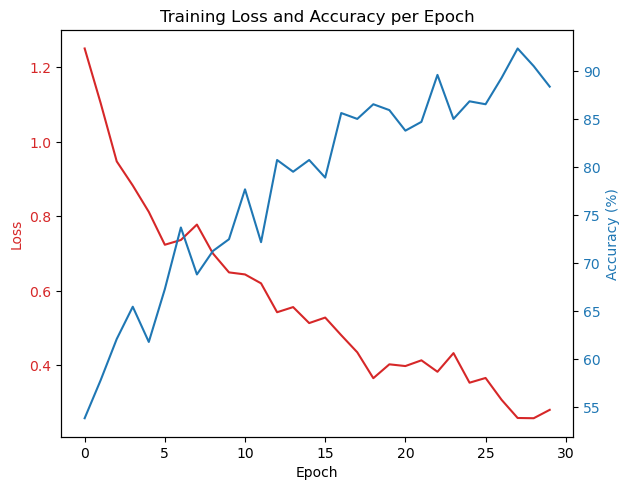

In [26]:
# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epoch_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epoch_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Accuracy per Epoch')
plt.show()

## Eval model

In [27]:
# evaluate model
def evaluate(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# print results
print(f"Training accuracy: {evaluate(train_loader)}%")
print(f"Testing accuracy: {evaluate(test_loader)}%")

Training accuracy: 92.66055045871559%
Testing accuracy: 87.8048780487805%


In [30]:
# Average soil compositions for each class in terms of
#        [sand, silt, clay]
soil_compositions = {
    "clay": [0, 0, 100],
    "silt": [0, 100, 0],
    "sand": [100, 0, 0],
    "silt loam": [0, 70, 30],
    "sandy loam": [70, 0, 30],
    "loam": [40, 40, 20],
    "sandy clay": [45, 0, 55],
    "silty clay": [0, 45, 55],
    "sandy clay loam": [58, 10, 32],
    "silty clay loam": [10, 58, 32]
}

softmax = nn.Softmax(dim=1)
probabilities = softmax(outputs) 


In [31]:
def predict_composition(outputs):
    # Get softmax probabilities
    probabilities = softmax(outputs).detach().numpy()
    
    # Calculate average soil composition based on model predictions
    avg_composition = [0, 0, 0]  # [sand, silt, clay]
    for i, soil_type in enumerate(soil_compositions.keys()):
        for j in range(3):
            avg_composition[j] += probabilities[0][i] * soil_compositions[soil_type][j]
            
    return avg_composition

predicted_compositions = predict_composition(outputs)
print(f"Predicted composition: Sand: {predicted_compositions[0]}%, Silt: {predicted_compositions[1]}%, Clay: {predicted_compositions[2]}%")


IndexError: index 5 is out of bounds for axis 0 with size 5